# UrbanSound8k Dataset Exploration

## Install Packages

We install: 
- Audio processing: `librosa`, `mutagen`
- Plots: `Plotly`, `matplotlib`

In [ ]:
!pip install pandas
!pip install librosa
!pip install plotly
!pip install matplotlib
!pip install mutagen
!pip install pillow

     |████████████████████████████████| 225kB 9.4MB/s 


In [ ]:
import os
import time
import librosa
import zipfile
import mutagen
import mutagen.wave
import numpy as np
import pandas as pd
import librosa.display
import IPython.display
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from PIL import Image

## Data Processing

In [ ]:
# Unzip dataset
!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O urban8k.tgz
!tar -xzf urban8k.tgz
!rm urban8k.tgz

--2020-12-09 11:52:53--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘urban8k.tgz’

urban8k.tgz         100%[===================>]   5.61G  6.52MB/s    in 11m 5s  

2020-12-09 12:03:59 (8.64 MB/s) - ‘urban8k.tgz’ saved [6023741708/6023741708]



In [ ]:
!cat UrbanSound8K/UrbanSound8K_README.txt

UrbanSound8K

Created By
----------

Justin Salamon*^, Christopher Jacoby* and Juan Pablo Bello*
* Music and Audio Research Lab (MARL), New York University, USA
^ Center for Urban Science and Progress (CUSP), New York University, USA
http://serv.cusp.nyu.edu/projects/urbansounddataset
http://marl.smusic.nyu.edu/
http://cusp.nyu.edu/

Version 1.0


Description
-----------

This dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, 
children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, and street_music. The classes are 
drawn from the urban sound taxonomy described in the following article, which also includes a detailed description of 
the dataset and how it was compiled:

J. Salamon, C. Jacoby and J. P. Bello, "A Dataset and Taxonomy for Urban Sound Research", 
22nd ACM International Conference on Multimedia, Orlando USA, Nov. 2014.

All excerpts are taken from field recordings uploaded to www.freesou

## Data Analysis

We will perform a set of data analysis steps to observe and see patterns in the data given and choose the best modeling accordingly. 

### Data Statistics
We want to see how the audio files were recorded and how the different classes are distributed.  




In [ ]:
def create_dataset_df(csv_file):
    dataset_df = pd.read_csv(csv_file)
    filepaths = []
    for i, row in dataset_df.iterrows():
        filepaths.append(os.path.join('UrbanSound8K/audio', 'fold'+str(row['fold']), row['slice_file_name']))
    dataset_df['filepath'] = filepaths
    return dataset_df

In [ ]:
dataset_df = create_dataset_df('UrbanSound8K/metadata/UrbanSound8K.csv')
dataset_df.head()

slice_file_name  ...                                     filepath
0    100032-3-0-0.wav  ...    UrbanSound8K/audio/fold5/100032-3-0-0.wav
1  100263-2-0-117.wav  ...  UrbanSound8K/audio/fold5/100263-2-0-117.wav
2  100263-2-0-121.wav  ...  UrbanSound8K/audio/fold5/100263-2-0-121.wav
3  100263-2-0-126.wav  ...  UrbanSound8K/audio/fold5/100263-2-0-126.wav
4  100263-2-0-137.wav  ...  UrbanSound8K/audio/fold5/100263-2-0-137.wav

[5 rows x 9 columns]

In [ ]:
dataset_df.groupby('class').slice_file_name.count()

class
air_conditioner     1000
car_horn             429
children_playing    1000
dog_bark            1000
drilling            1000
engine_idling       1000
gun_shot             374
jackhammer          1000
siren                929
street_music        1000
Name: slice_file_name, dtype: int64

We can observe all the classes except `car_horn`, `gun_shot` and `siren` have 1000 samples. We could explore options to include **class weights** in the loss function or **oversampling** if we see that the under-represented classes are not being classified as well as the rest.  

Next we compute the audio files statistics...

In [ ]:
def get_audio_metadata_mutagen(filepath):
    metadata = {}
    f = mutagen.wave.WAVE(filepath)
    metadata['length'] = f.info.length
    metadata['bitrate'] = f.info.bitrate
    metadata['channels'] = f.info.channels
    metadata['sample_rate'] = f.info.sample_rate
    metadata['bits_per_sample'] = f.info.bits_per_sample
    return metadata 
    

def compute_audio_statistics(dataset_df):
    metadata_dict = {'length': [], 'bitrate': [], 'channels': [], 'sample_rate': [], 'bits_per_sample': []} 
    # Extract metadata
    for filepath in dataset_df['filepath']:
        metadata = get_audio_metadata_mutagen(filepath)
        for key in metadata_dict.keys():
            metadata_dict[key].append(metadata[key])
    # Add new columns to dataframe
    for key in metadata_dict.keys():
        dataset_df[key] = metadata_dict[key]
    
    return dataset_df

In [ ]:
dataset_df = dataset_df.drop(columns=['fold', 'slice_file_name', 'fsID', 'start', 'end'])

In [ ]:
audio_statistics_df = compute_audio_statistics(dataset_df)

We can observe in the following tables that the data has been recorded and digitalized in different ways. 

- It has been mostly recorded using 2 channels in almost all the samples (stereo). 
- The sample rates go from 8kHz to 192kHz (mostly 44kHz, 48Khz)
- The length of the audios goes from 0.0008s to 4s (mostly 4s)
- The bits per sample used go from 4 to 32 (mostly 24 bits)

The data will need to be standardized before to be fed to a machine learning model. 

In [ ]:
audio_statistics_df.describe()

salience      classID  ...    sample_rate  bits_per_sample
count  8732.000000  8732.000000  ...    8732.000000      8732.000000
mean      1.347000     4.592877  ...   48456.979272        18.780119
std       0.476043     2.894544  ...   15300.080707         4.227168
min       1.000000     0.000000  ...    8000.000000         4.000000
25%       1.000000     2.000000  ...   44100.000000        16.000000
50%       1.000000     4.000000  ...   44100.000000        16.000000
75%       2.000000     7.000000  ...   48000.000000        24.000000
max       2.000000     9.000000  ...  192000.000000        32.000000

[8 rows x 7 columns]

In [ ]:
audio_statistics_df['sample_rate'].value_counts(), audio_statistics_df['bits_per_sample'].value_counts()

(44100     5370
 48000     2502
 96000      610
 24000       82
 16000       45
 22050       44
 11025       39
 192000      17
 8000        12
 11024        7
 32000        4
 Name: sample_rate, dtype: int64, 16    5758
 24    2753
 32     169
 8       43
 4        9
 Name: bits_per_sample, dtype: int64)

If we now look at the audio statistics per each of the different labels we see that:

- The length of the audios for the classes 1 and 6 is much smaller than for the rest of classes. Could be used as a feature if we wanted. 

- The rest of metadata is very similar for every class, can't see any trend. 

In [ ]:
audio_statistics_df.groupby('class').describe()

salience                           ... bits_per_sample                  
                    count      mean       std  min  ...             25%   50%   75%   max
class                                               ...                                  
air_conditioner    1000.0  1.431000  0.495464  1.0  ...            16.0  16.0  24.0  32.0
car_horn            429.0  1.643357  0.479567  1.0  ...            16.0  16.0  16.0  32.0
children_playing   1000.0  1.412000  0.492441  1.0  ...            16.0  16.0  24.0  24.0
dog_bark           1000.0  1.355000  0.478753  1.0  ...            16.0  16.0  24.0  32.0
drilling           1000.0  1.098000  0.297463  1.0  ...            16.0  16.0  24.0  32.0
engine_idling      1000.0  1.084000  0.277527  1.0  ...            16.0  16.0  24.0  32.0
gun_shot            374.0  1.187166  0.390567  1.0  ...            16.0  16.0  24.0  24.0
jackhammer         1000.0  1.269000  0.443662  1.0  ...            16.0  16.0  24.0  32.0
siren               929.0  1.710441  0.453802  1.0  ...            16.0  16.0  16.0  32.0
street_music       1000.0  1.375000  0.484365  1.0  ...            16.0  16.0  24.0  24.0

[10 rows x 56 columns]

### Data Visualization
As the data consists of Audio files we will use the `Librosa` library to load, plot and perform audio processing. 

We will use the `IPython.display.Audio` package to listen the files directly in the Jupyter Notebook. 

### Waveform

First we can visualize the waveform for different random samples of each class:

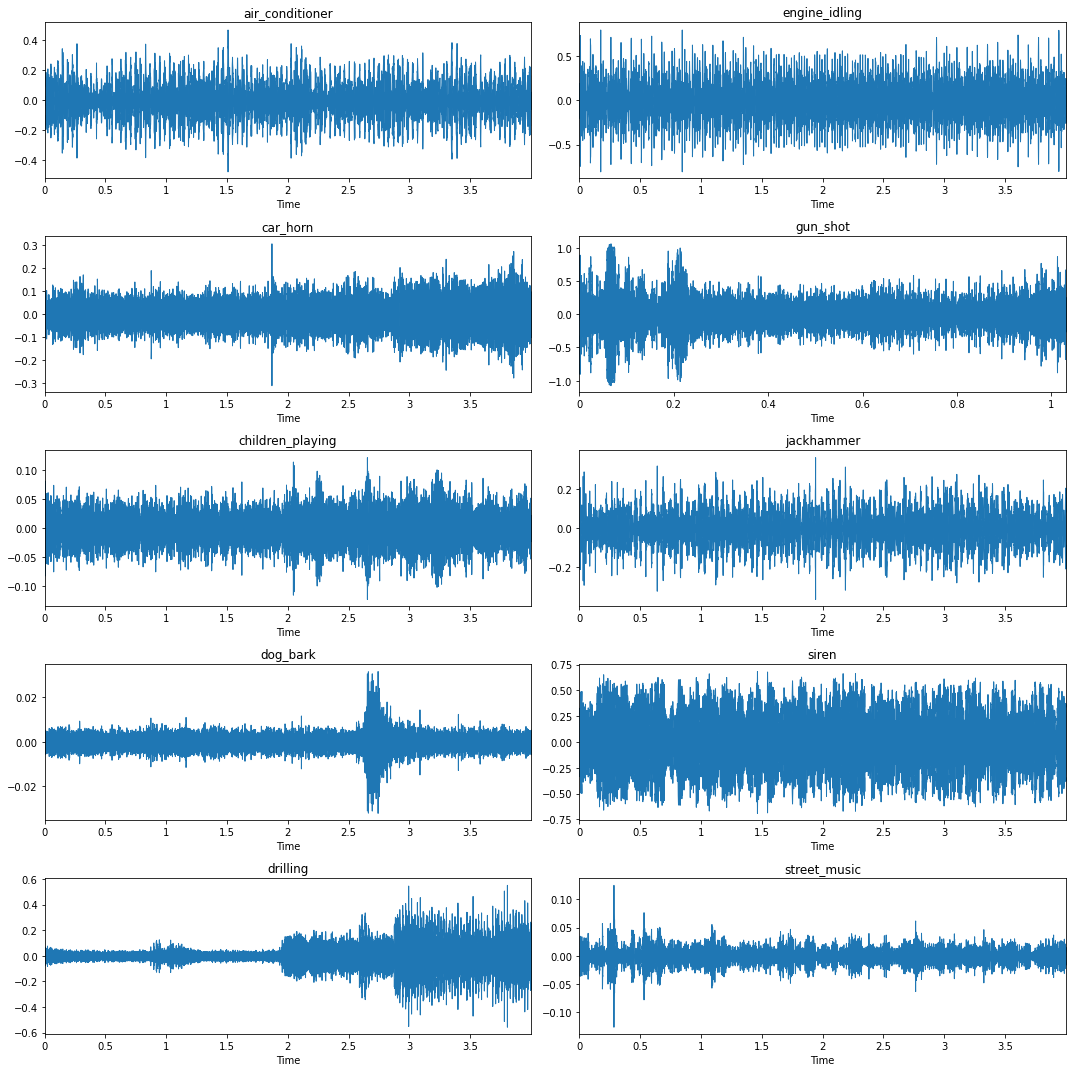

In [ ]:
# Randomly select one sample of each class
random_samples = dataset_df.groupby('class').sample(1)
audio_samples, labels = random_samples['filepath'].tolist(), random_samples['class'].tolist()

# Visualize the waveforms
fig, axs = plt.subplots(5, 2, figsize=(15,15))
index = 0
for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        librosa.display.waveplot(audio_file, sample_rate, ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()

STFT (Short-Term Fourier Transform), Mel-Spectograms and MFCC (Mel-Frequency Cepstral Coefficients) are all popular ways to process audio signals and generate features as input for machine learning algorithms such as Convolutional Neural Networks. 

### STFT (Log Y Axis)

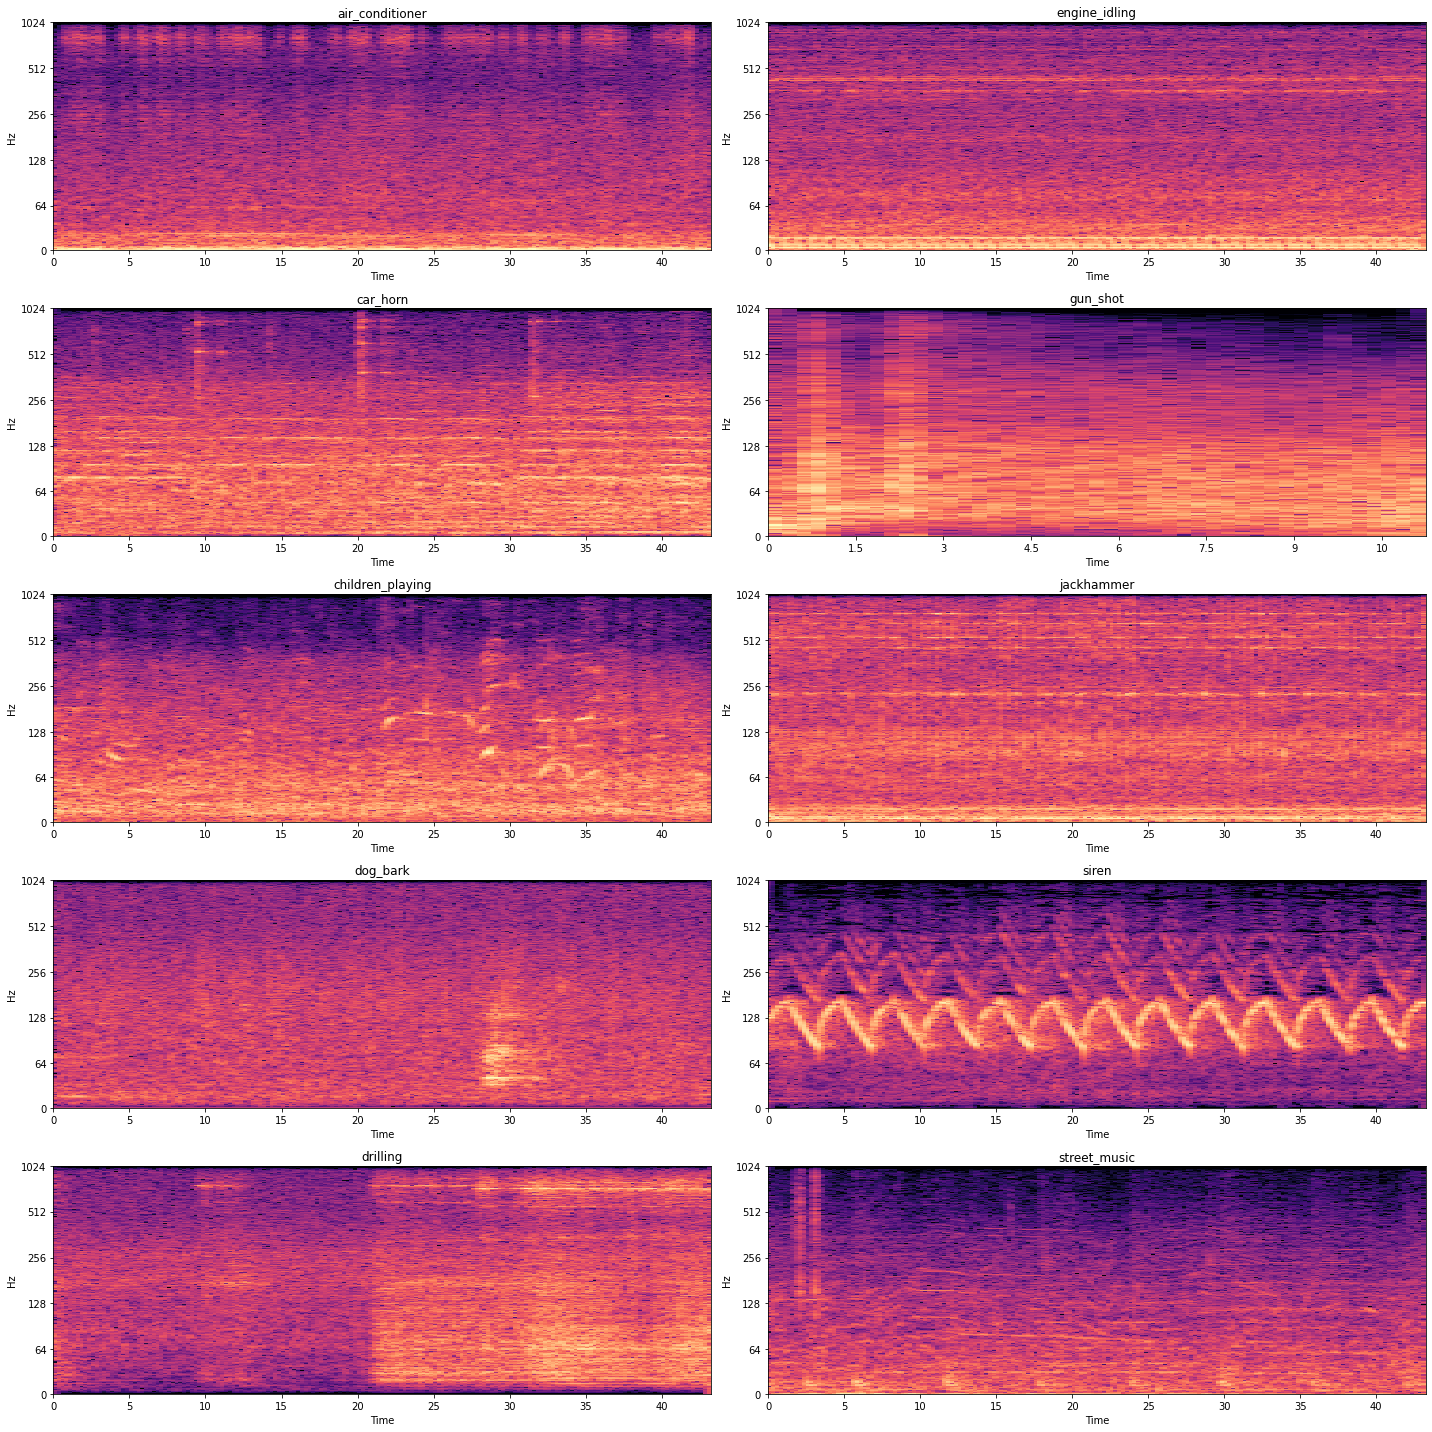

In [ ]:
# Visualize the STFT
n_fft = 2048
# Librosa default is n_fft // 4
hop_length = 512
fig, axs = plt.subplots(5, 2, figsize=(20,20))
index = 0
n_s = 4
for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        stft = librosa.stft(audio_file, n_fft, hop_length)  # STFT of y
        S_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
        librosa.display.specshow(S_db, 
                             sr=n_fft, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             y_axis='log',
                             ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()

### Mel-Spectogram

Next we will visualize the Mel-Spectogram which is a representation of the different frequencies magnitudes at different timesteps. The frequency magnitude is transformed to be on the Mel Scale, that takes into account how humans perceive and process audio signals.


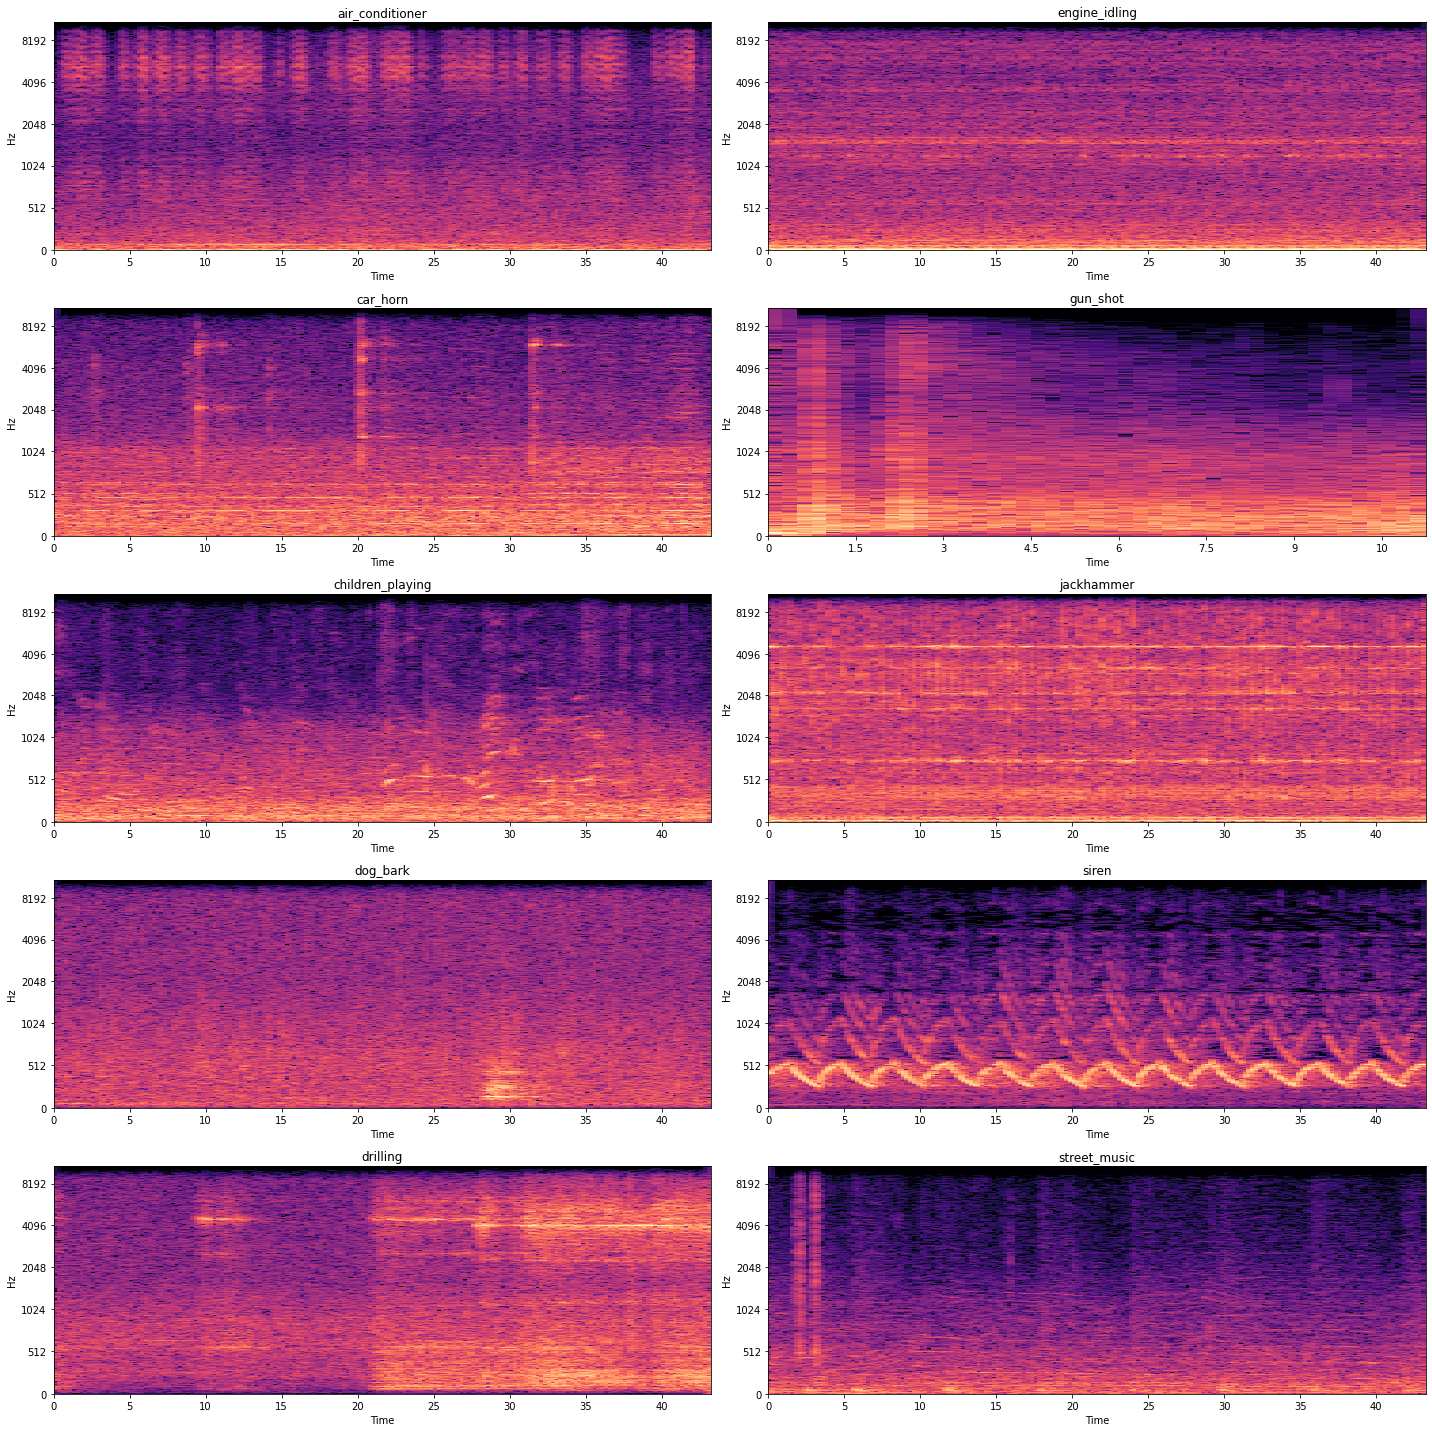

In [ ]:
# Visualize the Mel-Spectograms
n_fft = 2048
# Librosa default is n_fft // 4
hop_length = 512
fig, axs = plt.subplots(5, 2, figsize=(20,20))
index = 0
n_s = 4
for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        stft = librosa.stft(audio_file, n_fft, hop_length)  # STFT of y
        S_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
        librosa.display.specshow(S_db, 
                             sr=n_fft, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             y_axis='mel',
                             ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()


In [ ]:
# Listen to the recordings (index can be changed to listen to a different recording)
index = 0
print('Listen to {} sample'.format(labels[index]))
IPython.display.Audio(audio_samples[index])

Listen to air_conditioner sample


In [ ]:
audio_file, sample_rate = librosa.load(audio_samples[0])
stft = librosa.stft(audio_file)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
print(S_db.shape)
S_db

(1025, 173)


array([[ -9.272594 , -16.444105 , -35.585873 , ..., -30.500065 ,
        -26.819643 ,  -8.598801 ],
       [ -4.511669 ,  -9.653143 , -11.463926 , ..., -12.729481 ,
        -10.560596 ,  -7.737652 ],
       [ -5.0503426,  -2.9500961,  -2.9109077, ...,  -3.0178719,
         -2.7243042, -11.592571 ],
       ...,
       [-78.141464 , -80.       , -80.       , ..., -80.       ,
        -80.       , -80.       ],
       [-78.13403  , -80.       , -80.       , ..., -80.       ,
        -80.       , -80.       ],
       [-78.152435 , -80.       , -80.       , ..., -80.       ,
        -80.       , -80.       ]], dtype=float32)

### MFCCs

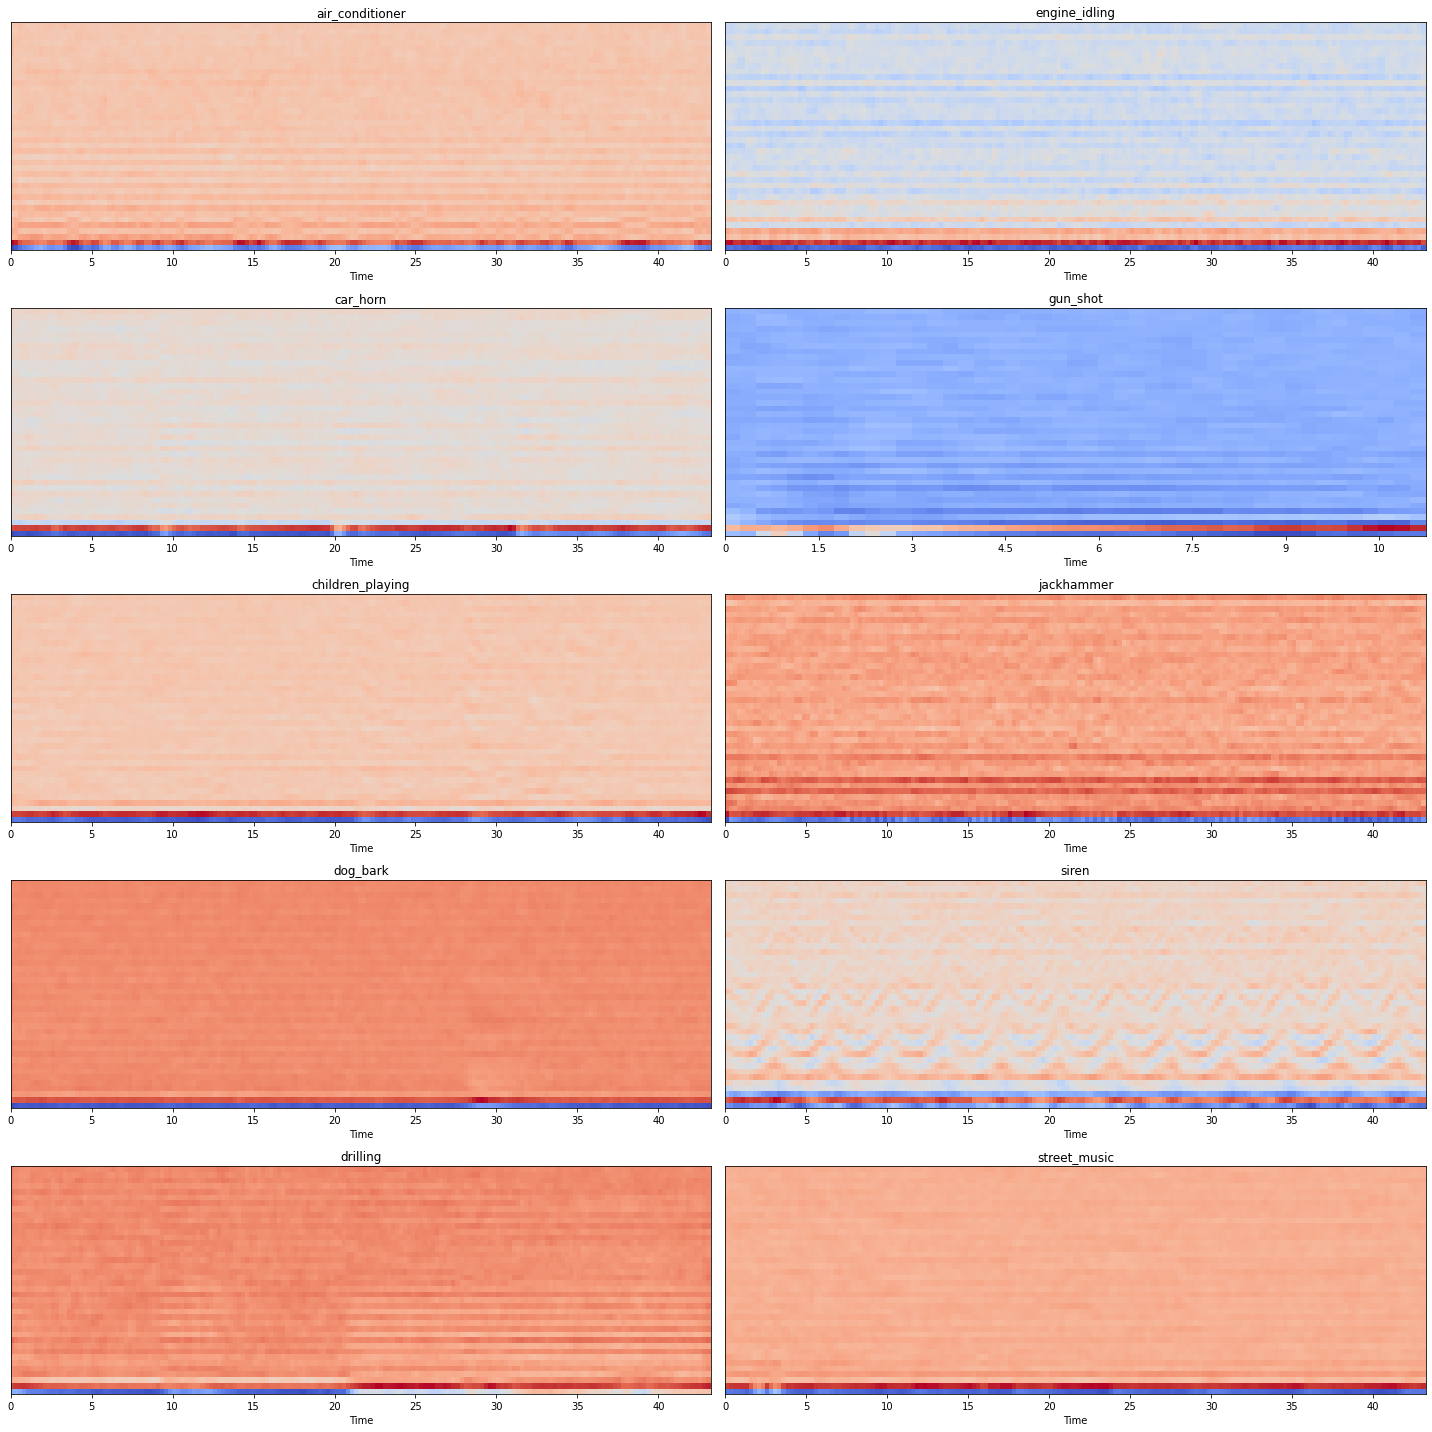

In [ ]:
# Visualize 40 MFCCs
n_fft = 2048
# Librosa default is n_fft // 4
hop_length = 512
fig, axs = plt.subplots(5, 2, figsize=(20,20))
index = 0
n_s = 4
for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        mfccs = librosa.feature.mfcc(audio_file,
                                    sr=sample_rate, 
                                    n_fft=n_fft,
                                    n_mfcc=40)
        librosa.display.specshow(mfccs, 
                             sr=n_fft, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()


After taking a look at the graphs for some different permutations, we can observe that the signals for the dataset classes are different enough to be classified correctly. 

We will use a machine learning algorithm to process this data and classify the different audio files. 